# Brain tumor 3D segmentation with MONAI

This tutorial shows how to construct a training workflow of multi-labels segmentation task.

And it contains below features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D SegResNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Deterministic training for reproducibility.

The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

----
데이터셋 설명(medicaldecathlon)
* 신경교종 segmentation (괴사/활성 종양 및 부종) - BranTumor
* modality(다중모드): Multimodal MRI (FLAIR, T1w, T1gd, T2w)
* 4D volumes(위 multimodal), total 750 imgs(484 train, 266 test)
* 소스 : BRATS 2016, 2017

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](../figures/brats_tasks.png)
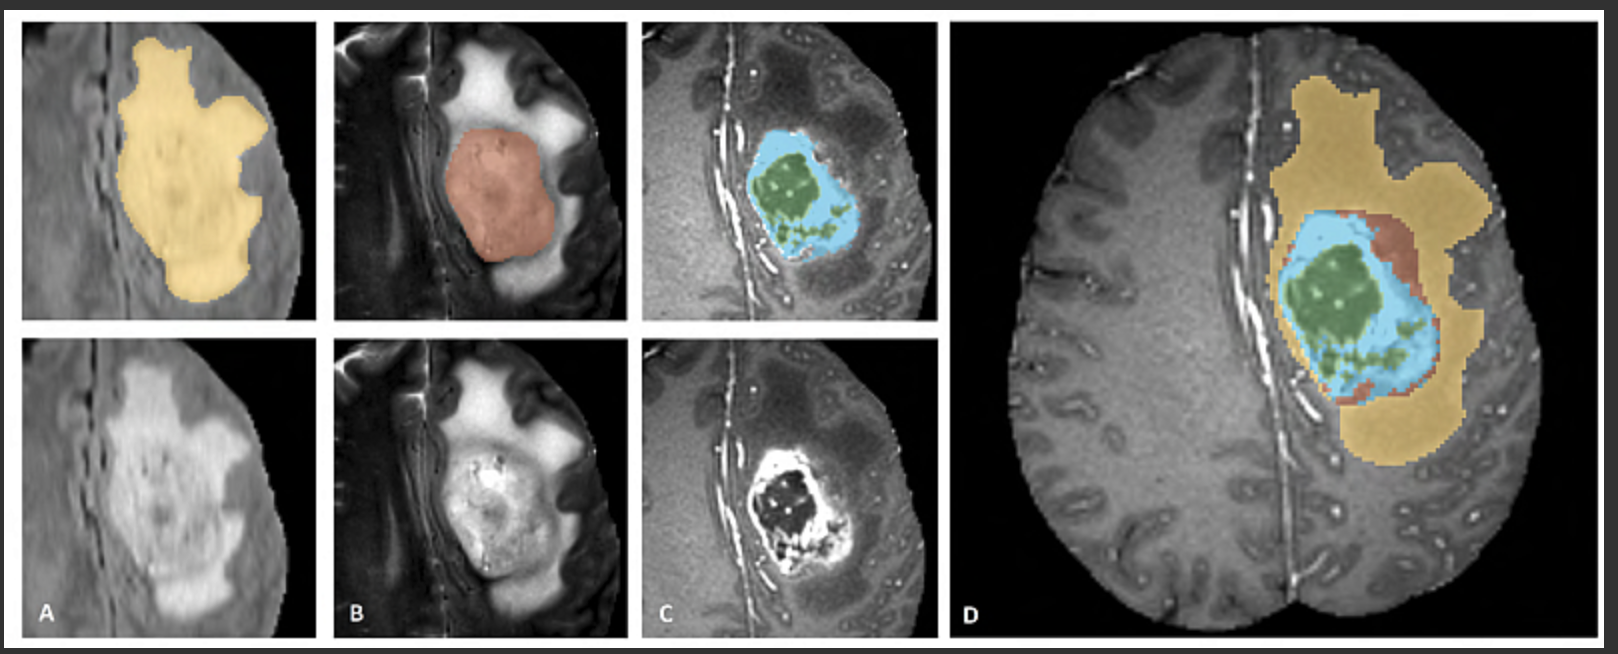

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb)

----
그림설명
1. T2-FLAIR에서 노란색 전체 종양(Fig A)
1. T2에서 보이는 종양코어 빨간색(Fig B)
1. T1Gd에서 보이는 강화종양(하늘색), 코어(녹색)
1. segmentation이 결합되어 Fig D의 최종 레이블 생성 - 부종(노랑), 비강화 solid core(빨강), necrotic/cystic core (녹색), enhancing core (파랑)

## Setup environment

In [1]:
# !python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
# !python -c "import matplotlib" || pip install -q matplotlib
# %matplotlib inline

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
)
from monai.utils import set_determinism

import torch

print_config()

MONAI version: 0.9.dev2152
Numpy version: 1.21.2
Pytorch version: 1.10.0a0+0aef44c
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: c5bd8aff8ba461d7b349eb92427d452481a7eb72

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.4.0
Tensorboard version: 2.6.0
gdown version: 4.2.0
TorchVision version: 0.11.0a0
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.4
einops version: 0.3.2
transformers version: 4.12.5
mlflow version: 1.21.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
# root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = 'data/brats'
print(root_dir)

data/brats


## Set deterministic training for reproducibility

In [4]:
set_determinism(seed=0)

## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

다중 클래스 레이블을 원핫 형식의 segmentation label 모양으로 변환

In [5]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema (주변부 부종)
    label 2 is the GD-enhancing tumor (강화종양)
    label 3 is the necrotic and non-enhancing tumor core (괴사 및 비증강 종양핵)
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).
    
    label 2 + 3 : TC(Tumor core)
    label 1+2+3 : WT(Whole tumor)
    label 2     : ET(Enhancing tumor)
    [TC(Tumor core), WT(Whole tumor), ET(Enhancing tumor)]
    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:    # "label"
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [64]:
# 어케 적용해야 하냐..
test_array = np.random.randint(1, 4, size=(1))
test_array = np.random.randint(1, 4, size=(2))
test_array = np.random.randint(1, 4, size=(2,2))
aaa = [{"label": test_array}]
print('before', aaa)
# aaa = [{"label": [[[2, 3, 1]]]}]
test_transform = Compose(
#     LoadImaged(keys=["label"]),
#     EnsureChannelFirstd(keys="image"),
    ConvertToMultiChannelBasedOnBratsClassesd(keys="label"))
after_aaa = test_transform(aaa)
after_aaa[0]['label'].shape, after_aaa[0]['label']

before [{'label': array([[3, 3],
       [1, 3]])}]


((3, 2, 2),
 array([[[1., 1.],
         [0., 1.]],
 
        [[1., 1.],
         [1., 1.]],
 
        [[0., 0.],
         [0., 0.]]], dtype=float32))

## Setup transforms for training and validation

In [65]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        
        # random augmentation
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        
        # random augmentation2
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        
        
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, if you want to use less memory, you can set `cache_num=N` to cache N items for training and use the defaut args to cache all the items for validation, it depends on your memory size.

In [66]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

Task01_BrainTumour.tar: 7.09GB [07:45, 16.3MB/s]                                                                                         


2022-02-04 01:54:04,621 - INFO - Downloaded: data/brats/Task01_BrainTumour.tar
2022-02-04 01:54:22,884 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2022-02-04 01:54:22,889 - INFO - Writing into directory: data/brats.


## Check data shape and visualize

image shape: torch.Size([4, 240, 240, 155])


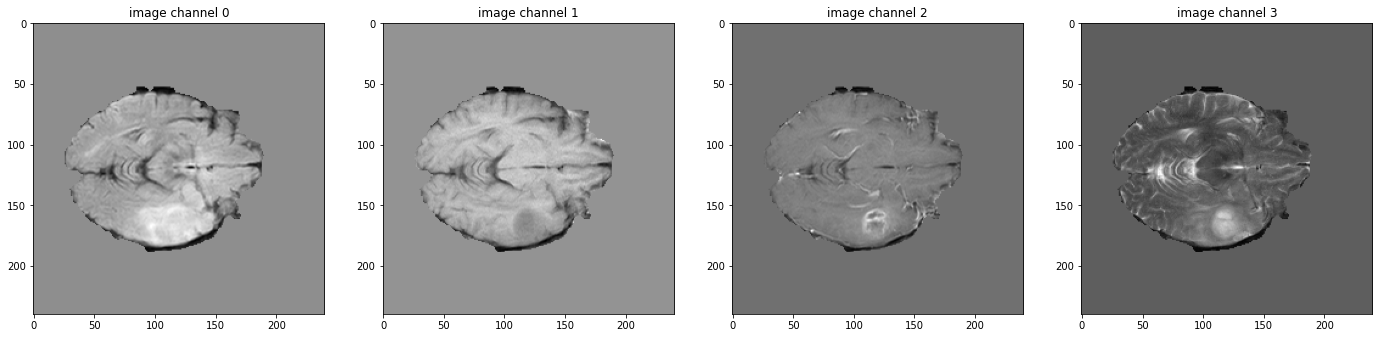

label shape: torch.Size([3, 240, 240, 155])


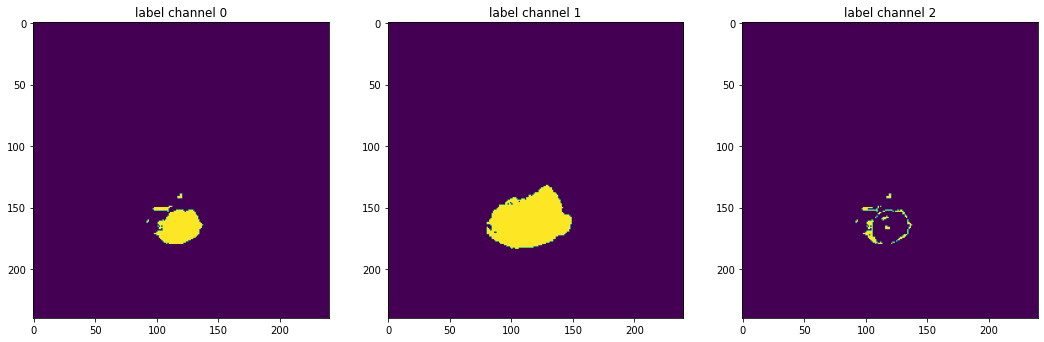

In [67]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
print(f"image shape: {val_ds[2]['image'].shape}")    # 4D(Multimodal MRI (FLAIR, T1w, T1gd, T2w)) - torch.Size([4, 240, 240, 155])
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_ds[2]["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_ds[2]['label'].shape}")   # torch.Size([3, 240, 240, 155]) - [TC(Tumor core), WT(Whole tumor), ET(Enhancing tumor)]
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_ds[2]["label"][i, :, :, 60].detach().cpu())
plt.show()

## Create Model, Loss, Optimizer

In [72]:
max_epochs = 300
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:6")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)


# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

## Execute a typical PyTorch training process

In [73]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

                
            # dice_metric은 tc, wt, et 모두의 평균인듯?
            # dice_metric_batch는 tc, wt, et 각각의 dice coefficient 평균인듯.
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            # 전체 dice mean metric이 높은 모델을 best로 뽑는다.
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            # 출력은 전체 평균과 각각 레벨의 성능을 출력
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300
1/388, train_loss: 0.9409, step time: 32.6081
2/388, train_loss: 0.9922, step time: 0.4594
3/388, train_loss: 0.9213, step time: 0.4625
4/388, train_loss: 0.9629, step time: 0.4388
5/388, train_loss: 0.9816, step time: 0.4720
6/388, train_loss: 0.9588, step time: 0.4338
7/388, train_loss: 0.9683, step time: 0.4477
8/388, train_loss: 0.9490, step time: 0.4564
9/388, train_loss: 0.9887, step time: 0.4285
10/388, train_loss: 0.9252, step time: 0.4136
11/388, train_loss: 0.9152, step time: 0.4033
12/388, train_loss: 0.9852, step time: 0.4041
13/388, train_loss: 0.9182, step time: 0.4097
14/388, train_loss: 0.8960, step time: 0.3904
15/388, train_loss: 0.9932, step time: 0.4020
16/388, train_loss: 0.9248, step time: 0.4099
17/388, train_loss: 0.9163, step time: 0.3999
18/388, train_loss: 0.9164, step time: 0.3994
19/388, train_loss: 0.9163, step time: 0.3995
20/388, train_loss: 0.9405, step time: 0.3982
21/388, train_loss: 0.9193, step time: 0.3981
22/388, train_loss:

178/388, train_loss: 0.8993, step time: 0.4119
179/388, train_loss: 0.8345, step time: 0.4014
180/388, train_loss: 0.9007, step time: 0.4152
181/388, train_loss: 0.8697, step time: 0.4088
182/388, train_loss: 0.8665, step time: 0.4091
183/388, train_loss: 0.9296, step time: 0.3995
184/388, train_loss: 0.8767, step time: 0.3936
185/388, train_loss: 0.9654, step time: 0.4075
186/388, train_loss: 0.9371, step time: 0.4024
187/388, train_loss: 0.8966, step time: 0.4063
188/388, train_loss: 0.8920, step time: 0.4111
189/388, train_loss: 0.8363, step time: 0.4098
190/388, train_loss: 0.9079, step time: 0.4068
191/388, train_loss: 0.8386, step time: 0.4025
192/388, train_loss: 0.8757, step time: 0.4072
193/388, train_loss: 0.8923, step time: 0.4112
194/388, train_loss: 0.9624, step time: 0.4051
195/388, train_loss: 0.8831, step time: 0.4027
196/388, train_loss: 0.8721, step time: 0.4092
197/388, train_loss: 0.9143, step time: 0.4010
198/388, train_loss: 0.9152, step time: 0.4155
199/388, trai

353/388, train_loss: 0.8429, step time: 0.4014
354/388, train_loss: 0.8682, step time: 0.4059
355/388, train_loss: 0.8552, step time: 0.4060
356/388, train_loss: 0.8464, step time: 0.4024
357/388, train_loss: 0.8918, step time: 0.3977
358/388, train_loss: 0.7713, step time: 0.4150
359/388, train_loss: 0.7697, step time: 0.4042
360/388, train_loss: 0.8851, step time: 0.4116
361/388, train_loss: 0.7685, step time: 0.4056
362/388, train_loss: 0.9008, step time: 0.4030
363/388, train_loss: 0.7899, step time: 0.4056
364/388, train_loss: 0.7995, step time: 0.4135
365/388, train_loss: 0.8792, step time: 0.4017
366/388, train_loss: 0.8359, step time: 0.4073
367/388, train_loss: 0.8640, step time: 0.4036
368/388, train_loss: 0.8559, step time: 0.4098
369/388, train_loss: 0.8037, step time: 0.3918
370/388, train_loss: 0.8367, step time: 0.4066
371/388, train_loss: 0.8930, step time: 0.4062
372/388, train_loss: 0.9485, step time: 0.4012
373/388, train_loss: 0.9770, step time: 0.3984
374/388, trai

137/388, train_loss: 0.8257, step time: 0.3887
138/388, train_loss: 0.7794, step time: 0.3893
139/388, train_loss: 0.7558, step time: 0.3892
140/388, train_loss: 0.9358, step time: 0.3965
141/388, train_loss: 0.8258, step time: 0.3911
142/388, train_loss: 0.7686, step time: 0.3908
143/388, train_loss: 0.7715, step time: 0.4065
144/388, train_loss: 0.8338, step time: 0.4012
145/388, train_loss: 0.9001, step time: 0.3912
146/388, train_loss: 0.8119, step time: 0.3904
147/388, train_loss: 0.8883, step time: 0.3982
148/388, train_loss: 0.9474, step time: 0.4018
149/388, train_loss: 0.8348, step time: 0.4008
150/388, train_loss: 0.7935, step time: 0.4031
151/388, train_loss: 0.9522, step time: 0.3930
152/388, train_loss: 0.7892, step time: 0.3890
153/388, train_loss: 0.8283, step time: 0.3892
154/388, train_loss: 0.9273, step time: 0.3846
155/388, train_loss: 0.8685, step time: 0.3890
156/388, train_loss: 0.7579, step time: 0.3905
157/388, train_loss: 0.8430, step time: 0.3891
158/388, trai

312/388, train_loss: 0.8582, step time: 0.4056
313/388, train_loss: 0.7644, step time: 0.4040
314/388, train_loss: 0.7423, step time: 0.4016
315/388, train_loss: 0.9048, step time: 0.4053
316/388, train_loss: 0.8070, step time: 0.4049
317/388, train_loss: 0.7698, step time: 0.4098
318/388, train_loss: 0.7090, step time: 0.4101
319/388, train_loss: 0.7397, step time: 0.4024
320/388, train_loss: 0.8519, step time: 0.4014
321/388, train_loss: 0.8530, step time: 0.4023
322/388, train_loss: 0.6597, step time: 0.4023
323/388, train_loss: 0.7102, step time: 0.4047
324/388, train_loss: 0.9503, step time: 0.4060
325/388, train_loss: 0.8835, step time: 0.4110
326/388, train_loss: 0.8404, step time: 0.3969
327/388, train_loss: 0.7825, step time: 0.4007
328/388, train_loss: 0.7816, step time: 0.4083
329/388, train_loss: 0.8044, step time: 0.3926
330/388, train_loss: 0.7172, step time: 0.3960
331/388, train_loss: 0.7989, step time: 0.4078
332/388, train_loss: 0.8353, step time: 0.3912
333/388, trai

96/388, train_loss: 0.7046, step time: 0.4080
97/388, train_loss: 0.7512, step time: 0.4019
98/388, train_loss: 0.8162, step time: 0.4040
99/388, train_loss: 0.7092, step time: 0.3916
100/388, train_loss: 0.7419, step time: 0.4042
101/388, train_loss: 0.6957, step time: 0.4086
102/388, train_loss: 0.8668, step time: 0.4027
103/388, train_loss: 0.6614, step time: 0.4018
104/388, train_loss: 0.9535, step time: 0.4010
105/388, train_loss: 0.7703, step time: 0.4108
106/388, train_loss: 0.7355, step time: 0.3942
107/388, train_loss: 0.6920, step time: 0.3967
108/388, train_loss: 0.7679, step time: 0.4005
109/388, train_loss: 0.6815, step time: 0.4086
110/388, train_loss: 0.7103, step time: 0.3916
111/388, train_loss: 0.6637, step time: 0.3957
112/388, train_loss: 0.8177, step time: 0.3956
113/388, train_loss: 0.7475, step time: 0.4102
114/388, train_loss: 0.6939, step time: 0.3918
115/388, train_loss: 0.6979, step time: 0.3998
116/388, train_loss: 0.8076, step time: 0.3993
117/388, train_lo

271/388, train_loss: 0.7980, step time: 0.3927
272/388, train_loss: 0.7512, step time: 0.3928
273/388, train_loss: 0.6366, step time: 0.3912
274/388, train_loss: 0.7458, step time: 0.3997
275/388, train_loss: 0.7224, step time: 0.4024
276/388, train_loss: 0.6734, step time: 0.3965
277/388, train_loss: 0.7626, step time: 0.3959
278/388, train_loss: 0.7302, step time: 0.3939
279/388, train_loss: 0.7574, step time: 0.3969
280/388, train_loss: 0.5992, step time: 0.3978
281/388, train_loss: 0.7758, step time: 0.3978
282/388, train_loss: 0.7578, step time: 0.3927
283/388, train_loss: 0.7115, step time: 0.3953
284/388, train_loss: 0.9155, step time: 0.3921
285/388, train_loss: 0.7810, step time: 0.3935
286/388, train_loss: 0.6786, step time: 0.3901
287/388, train_loss: 0.8175, step time: 0.3966
288/388, train_loss: 0.7654, step time: 0.3994
289/388, train_loss: 0.6700, step time: 0.3951
290/388, train_loss: 0.7652, step time: 0.3871
291/388, train_loss: 0.6984, step time: 0.3864
292/388, trai

54/388, train_loss: 0.6458, step time: 0.4081
55/388, train_loss: 0.7631, step time: 0.4165
56/388, train_loss: 0.6158, step time: 0.4025
57/388, train_loss: 0.5893, step time: 0.4031
58/388, train_loss: 0.5942, step time: 0.4180
59/388, train_loss: 0.6238, step time: 0.4010
60/388, train_loss: 0.6051, step time: 0.4202
61/388, train_loss: 0.7226, step time: 0.4002
62/388, train_loss: 0.8810, step time: 0.4018
63/388, train_loss: 0.6790, step time: 0.4093
64/388, train_loss: 0.6549, step time: 0.4162
65/388, train_loss: 0.7262, step time: 0.3988
66/388, train_loss: 0.7311, step time: 0.3999
67/388, train_loss: 0.6940, step time: 0.4013
68/388, train_loss: 0.8232, step time: 0.4009
69/388, train_loss: 0.7112, step time: 0.4008
70/388, train_loss: 0.8160, step time: 0.3998
71/388, train_loss: 0.7571, step time: 0.4014
72/388, train_loss: 0.7034, step time: 0.4027
73/388, train_loss: 0.8466, step time: 0.4029
74/388, train_loss: 0.7657, step time: 0.4045
75/388, train_loss: 0.7154, step t

230/388, train_loss: 0.5956, step time: 0.3916
231/388, train_loss: 0.6749, step time: 0.3895
232/388, train_loss: 0.6380, step time: 0.3879
233/388, train_loss: 0.7723, step time: 0.3916
234/388, train_loss: 0.6617, step time: 0.3909
235/388, train_loss: 0.6778, step time: 0.3961
236/388, train_loss: 0.7151, step time: 0.3980
237/388, train_loss: 0.7992, step time: 0.3947
238/388, train_loss: 0.7472, step time: 0.3952
239/388, train_loss: 0.9342, step time: 0.3926
240/388, train_loss: 0.6350, step time: 0.3949
241/388, train_loss: 0.7345, step time: 0.3909
242/388, train_loss: 0.5789, step time: 0.3949
243/388, train_loss: 0.6264, step time: 0.3909
244/388, train_loss: 0.5895, step time: 0.3969
245/388, train_loss: 0.5533, step time: 0.3911
246/388, train_loss: 0.6427, step time: 0.3929
247/388, train_loss: 0.5088, step time: 0.3952
248/388, train_loss: 0.8550, step time: 0.3933
249/388, train_loss: 0.6693, step time: 0.3897
250/388, train_loss: 0.6290, step time: 0.3919
251/388, trai

12/388, train_loss: 0.6043, step time: 0.4016
13/388, train_loss: 0.7843, step time: 0.4000
14/388, train_loss: 0.7031, step time: 0.3996
15/388, train_loss: 0.5981, step time: 0.4006
16/388, train_loss: 0.7162, step time: 0.4050
17/388, train_loss: 0.5679, step time: 0.4001
18/388, train_loss: 0.6483, step time: 0.4015
19/388, train_loss: 0.7363, step time: 0.4011
20/388, train_loss: 0.7025, step time: 0.3997
21/388, train_loss: 0.7011, step time: 0.3976
22/388, train_loss: 0.6530, step time: 0.3967
23/388, train_loss: 0.6947, step time: 0.4016
24/388, train_loss: 0.7707, step time: 0.3998
25/388, train_loss: 0.6283, step time: 0.4103
26/388, train_loss: 0.6569, step time: 0.3991
27/388, train_loss: 0.5997, step time: 0.3988
28/388, train_loss: 0.6153, step time: 0.3989
29/388, train_loss: 0.8488, step time: 0.3994
30/388, train_loss: 0.6071, step time: 0.4050
31/388, train_loss: 0.6284, step time: 0.3995
32/388, train_loss: 0.6456, step time: 0.4011
33/388, train_loss: 0.7871, step t

189/388, train_loss: 0.6258, step time: 0.3912
190/388, train_loss: 0.4443, step time: 0.4026
191/388, train_loss: 0.4166, step time: 0.4008
192/388, train_loss: 0.6903, step time: 0.3926
193/388, train_loss: 0.5470, step time: 0.4015
194/388, train_loss: 0.7270, step time: 0.4017
195/388, train_loss: 0.7193, step time: 0.3983
196/388, train_loss: 0.6495, step time: 0.4034
197/388, train_loss: 0.5146, step time: 0.4029
198/388, train_loss: 0.5687, step time: 0.4154
199/388, train_loss: 0.5507, step time: 0.3982
200/388, train_loss: 0.6637, step time: 0.4028
201/388, train_loss: 0.6057, step time: 0.3913
202/388, train_loss: 0.6000, step time: 0.3907
203/388, train_loss: 0.6243, step time: 0.4040
204/388, train_loss: 0.5852, step time: 0.3913
205/388, train_loss: 0.7754, step time: 0.4009
206/388, train_loss: 0.5983, step time: 0.3929
207/388, train_loss: 0.5640, step time: 0.3912
208/388, train_loss: 0.5574, step time: 0.3932
209/388, train_loss: 0.6821, step time: 0.3911
210/388, trai

364/388, train_loss: 0.5250, step time: 0.3963
365/388, train_loss: 0.6554, step time: 0.3931
366/388, train_loss: 0.6679, step time: 0.3904
367/388, train_loss: 0.5365, step time: 0.3913
368/388, train_loss: 0.4721, step time: 0.4102
369/388, train_loss: 0.6313, step time: 0.4032
370/388, train_loss: 0.5853, step time: 0.4021
371/388, train_loss: 0.6095, step time: 0.4046
372/388, train_loss: 0.5972, step time: 0.4056
373/388, train_loss: 0.7106, step time: 0.4020
374/388, train_loss: 0.6453, step time: 0.4021
375/388, train_loss: 0.5648, step time: 0.4058
376/388, train_loss: 0.5491, step time: 0.4003
377/388, train_loss: 0.7743, step time: 0.4041
378/388, train_loss: 0.7305, step time: 0.3974
379/388, train_loss: 0.7392, step time: 0.4052
380/388, train_loss: 0.6141, step time: 0.3931
381/388, train_loss: 0.6750, step time: 0.3932
382/388, train_loss: 0.6314, step time: 0.3912
383/388, train_loss: 0.6613, step time: 0.3964
384/388, train_loss: 0.9066, step time: 0.3989
385/388, trai

148/388, train_loss: 0.4235, step time: 0.4041
149/388, train_loss: 0.4867, step time: 0.4100
150/388, train_loss: 0.6774, step time: 0.4009
151/388, train_loss: 0.5164, step time: 0.4019
152/388, train_loss: 0.3011, step time: 0.4047
153/388, train_loss: 0.5990, step time: 0.4020
154/388, train_loss: 0.5284, step time: 0.4014
155/388, train_loss: 0.5191, step time: 0.4035
156/388, train_loss: 0.6619, step time: 0.4061
157/388, train_loss: 0.4016, step time: 0.4059
158/388, train_loss: 0.5070, step time: 0.4056
159/388, train_loss: 0.5380, step time: 0.4021
160/388, train_loss: 0.5961, step time: 0.4055
161/388, train_loss: 0.3042, step time: 0.4052
162/388, train_loss: 0.5610, step time: 0.4057
163/388, train_loss: 0.4502, step time: 0.3959
164/388, train_loss: 0.5555, step time: 0.3972
165/388, train_loss: 0.6246, step time: 0.3931
166/388, train_loss: 0.4612, step time: 0.3945
167/388, train_loss: 0.4585, step time: 0.3883
168/388, train_loss: 0.5439, step time: 0.3897
169/388, trai

323/388, train_loss: 0.5083, step time: 0.3972
324/388, train_loss: 0.3924, step time: 0.3976
325/388, train_loss: 0.4764, step time: 0.3974
326/388, train_loss: 0.2807, step time: 0.3983
327/388, train_loss: 0.4661, step time: 0.3972
328/388, train_loss: 0.3647, step time: 0.3998
329/388, train_loss: 0.4095, step time: 0.3992
330/388, train_loss: 0.4844, step time: 0.3984
331/388, train_loss: 0.5757, step time: 0.3987
332/388, train_loss: 0.5586, step time: 0.3993
333/388, train_loss: 0.4059, step time: 0.3981
334/388, train_loss: 0.4042, step time: 0.3962
335/388, train_loss: 0.3906, step time: 0.3931
336/388, train_loss: 0.4025, step time: 0.4047
337/388, train_loss: 0.7525, step time: 0.3942
338/388, train_loss: 0.6621, step time: 0.3963
339/388, train_loss: 0.3025, step time: 0.3928
340/388, train_loss: 0.4016, step time: 0.3985
341/388, train_loss: 0.4184, step time: 0.4045
342/388, train_loss: 0.8294, step time: 0.4008
343/388, train_loss: 0.3193, step time: 0.3965
344/388, trai

107/388, train_loss: 0.5334, step time: 0.4012
108/388, train_loss: 0.3642, step time: 0.4015
109/388, train_loss: 0.3960, step time: 0.4016
110/388, train_loss: 0.6098, step time: 0.4024
111/388, train_loss: 0.4193, step time: 0.3917
112/388, train_loss: 0.3293, step time: 0.3908
113/388, train_loss: 0.4832, step time: 0.3863
114/388, train_loss: 0.2422, step time: 0.3872
115/388, train_loss: 0.3549, step time: 0.3867
116/388, train_loss: 0.7749, step time: 0.3903
117/388, train_loss: 0.4441, step time: 0.3909
118/388, train_loss: 0.6932, step time: 0.3894
119/388, train_loss: 0.2570, step time: 0.3909
120/388, train_loss: 0.3557, step time: 0.4001
121/388, train_loss: 0.3598, step time: 0.4116
122/388, train_loss: 0.6260, step time: 0.3934
123/388, train_loss: 0.1863, step time: 0.3898
124/388, train_loss: 0.4969, step time: 0.3911
125/388, train_loss: 0.5113, step time: 0.4011
126/388, train_loss: 0.6140, step time: 0.4013
127/388, train_loss: 0.1741, step time: 0.4051
128/388, trai

282/388, train_loss: 0.3575, step time: 0.4026
283/388, train_loss: 0.3196, step time: 0.3973
284/388, train_loss: 0.4110, step time: 0.3993
285/388, train_loss: 0.3911, step time: 0.3998
286/388, train_loss: 0.5082, step time: 0.4004
287/388, train_loss: 0.3705, step time: 0.4071
288/388, train_loss: 0.2449, step time: 0.3986
289/388, train_loss: 0.4277, step time: 0.3938
290/388, train_loss: 0.4267, step time: 0.3964
291/388, train_loss: 0.7818, step time: 0.4082
292/388, train_loss: 0.3833, step time: 0.3952
293/388, train_loss: 0.4354, step time: 0.3991
294/388, train_loss: 0.3459, step time: 0.4040
295/388, train_loss: 0.4340, step time: 0.3895
296/388, train_loss: 0.2444, step time: 0.3945
297/388, train_loss: 0.3222, step time: 0.3999
298/388, train_loss: 0.4270, step time: 0.3984
299/388, train_loss: 0.4617, step time: 0.3903
300/388, train_loss: 0.5624, step time: 0.3895
301/388, train_loss: 0.3741, step time: 0.3951
302/388, train_loss: 0.6423, step time: 0.3928
303/388, trai

65/388, train_loss: 0.4895, step time: 0.4013
66/388, train_loss: 0.3270, step time: 0.4024
67/388, train_loss: 0.7019, step time: 0.4013
68/388, train_loss: 0.3148, step time: 0.3994
69/388, train_loss: 0.2514, step time: 0.4087
70/388, train_loss: 0.3677, step time: 0.3936
71/388, train_loss: 0.3094, step time: 0.3930
72/388, train_loss: 0.3427, step time: 0.3986
73/388, train_loss: 0.4927, step time: 0.4027
74/388, train_loss: 0.4138, step time: 0.3881
75/388, train_loss: 0.5538, step time: 0.4065
76/388, train_loss: 0.3705, step time: 0.4052
77/388, train_loss: 0.2808, step time: 0.4100
78/388, train_loss: 0.2406, step time: 0.3981
79/388, train_loss: 0.3926, step time: 0.3908
80/388, train_loss: 0.3902, step time: 0.3983
81/388, train_loss: 0.3640, step time: 0.4082
82/388, train_loss: 0.6602, step time: 0.4057
83/388, train_loss: 0.4970, step time: 0.4030
84/388, train_loss: 0.5199, step time: 0.4067
85/388, train_loss: 0.4414, step time: 0.4182
86/388, train_loss: 0.3115, step t

241/388, train_loss: 0.1842, step time: 0.3892
242/388, train_loss: 0.3406, step time: 0.3897
243/388, train_loss: 0.3216, step time: 0.3906
244/388, train_loss: 0.3394, step time: 0.4042
245/388, train_loss: 0.3623, step time: 0.4028
246/388, train_loss: 0.7477, step time: 0.4156
247/388, train_loss: 0.3682, step time: 0.3917
248/388, train_loss: 0.7808, step time: 0.4167
249/388, train_loss: 0.2990, step time: 0.3902
250/388, train_loss: 0.3659, step time: 0.3959
251/388, train_loss: 0.6025, step time: 0.3969
252/388, train_loss: 0.3171, step time: 0.4048
253/388, train_loss: 0.3484, step time: 0.4021
254/388, train_loss: 0.3545, step time: 0.4032
255/388, train_loss: 0.3858, step time: 0.4059
256/388, train_loss: 0.4204, step time: 0.4008
257/388, train_loss: 0.4324, step time: 0.4021
258/388, train_loss: 0.3802, step time: 0.4003
259/388, train_loss: 0.2680, step time: 0.4036
260/388, train_loss: 0.2731, step time: 0.4003
261/388, train_loss: 0.2735, step time: 0.4068
262/388, trai

24/388, train_loss: 0.4376, step time: 0.3997
25/388, train_loss: 0.1947, step time: 0.3985
26/388, train_loss: 0.1537, step time: 0.4043
27/388, train_loss: 0.2047, step time: 0.4011
28/388, train_loss: 0.2379, step time: 0.3990
29/388, train_loss: 0.4112, step time: 0.3989
30/388, train_loss: 0.2692, step time: 0.3995
31/388, train_loss: 0.1913, step time: 0.3993
32/388, train_loss: 0.3440, step time: 0.4014
33/388, train_loss: 0.3209, step time: 0.3978
34/388, train_loss: 0.3548, step time: 0.3986
35/388, train_loss: 0.2813, step time: 0.4017
36/388, train_loss: 0.1894, step time: 0.4158
37/388, train_loss: 0.2584, step time: 0.4031
38/388, train_loss: 0.2746, step time: 0.4058
39/388, train_loss: 0.1838, step time: 0.4036
40/388, train_loss: 0.3277, step time: 0.4028
41/388, train_loss: 0.1544, step time: 0.3998
42/388, train_loss: 0.2802, step time: 0.4037
43/388, train_loss: 0.3749, step time: 0.4035
44/388, train_loss: 0.6246, step time: 0.4013
45/388, train_loss: 0.2523, step t

200/388, train_loss: 0.2706, step time: 0.4039
201/388, train_loss: 0.2552, step time: 0.4059
202/388, train_loss: 0.2238, step time: 0.4052
203/388, train_loss: 0.3707, step time: 0.4175
204/388, train_loss: 0.3298, step time: 0.4056
205/388, train_loss: 0.5227, step time: 0.4055
206/388, train_loss: 0.1995, step time: 0.4095
207/388, train_loss: 0.3424, step time: 0.4099
208/388, train_loss: 0.4681, step time: 0.4064
209/388, train_loss: 0.3721, step time: 0.4029
210/388, train_loss: 0.3451, step time: 0.4067
211/388, train_loss: 0.5262, step time: 0.4103
212/388, train_loss: 0.3189, step time: 0.4049
213/388, train_loss: 0.4311, step time: 0.4069
214/388, train_loss: 0.2536, step time: 0.4064
215/388, train_loss: 0.3921, step time: 0.4077
216/388, train_loss: 0.2735, step time: 0.4088
217/388, train_loss: 0.4476, step time: 0.4048
218/388, train_loss: 0.2177, step time: 0.4073
219/388, train_loss: 0.3315, step time: 0.4149
220/388, train_loss: 0.3052, step time: 0.4266
221/388, trai

375/388, train_loss: 0.1431, step time: 0.4105
376/388, train_loss: 0.3367, step time: 0.4039
377/388, train_loss: 0.1444, step time: 0.4014
378/388, train_loss: 0.7459, step time: 0.3962
379/388, train_loss: 0.4809, step time: 0.4012
380/388, train_loss: 0.2196, step time: 0.3945
381/388, train_loss: 0.2360, step time: 0.3954
382/388, train_loss: 0.2162, step time: 0.3997
383/388, train_loss: 0.4112, step time: 0.4064
384/388, train_loss: 0.3278, step time: 0.4036
385/388, train_loss: 0.1609, step time: 0.4007
386/388, train_loss: 0.2900, step time: 0.3983
387/388, train_loss: 0.6082, step time: 0.4033
388/388, train_loss: 0.2658, step time: 0.4009
epoch 9 average loss: 0.3393
current epoch: 9 current mean dice: 0.6667 tc: 0.7123 wt: 0.8516 et: 0.4362
best mean dice: 0.6695 at epoch: 8
time consuming of epoch 9 is: 255.6059
----------
epoch 10/300
1/388, train_loss: 0.2411, step time: 0.4217
2/388, train_loss: 0.7883, step time: 0.4043
3/388, train_loss: 0.1985, step time: 0.4037
4/38

160/388, train_loss: 0.2551, step time: 0.4069
161/388, train_loss: 0.2454, step time: 0.4082
162/388, train_loss: 0.2439, step time: 0.4053
163/388, train_loss: 0.2718, step time: 0.4039
164/388, train_loss: 0.2645, step time: 0.4004
165/388, train_loss: 0.1291, step time: 0.4028
166/388, train_loss: 0.2920, step time: 0.4028
167/388, train_loss: 0.3950, step time: 0.4125
168/388, train_loss: 0.7837, step time: 0.4046
169/388, train_loss: 0.1591, step time: 0.3998
170/388, train_loss: 0.3681, step time: 0.3978
171/388, train_loss: 0.1357, step time: 0.4004
172/388, train_loss: 0.3139, step time: 0.4011
173/388, train_loss: 0.5558, step time: 0.4000
174/388, train_loss: 0.2497, step time: 0.4028
175/388, train_loss: 0.1746, step time: 0.4026
176/388, train_loss: 0.4888, step time: 0.4045
177/388, train_loss: 0.3029, step time: 0.4069
178/388, train_loss: 0.4368, step time: 0.4060
179/388, train_loss: 0.1278, step time: 0.4014
180/388, train_loss: 0.2474, step time: 0.4050
181/388, trai

335/388, train_loss: 0.1179, step time: 0.4059
336/388, train_loss: 0.3263, step time: 0.4011
337/388, train_loss: 0.3154, step time: 0.4039
338/388, train_loss: 0.1673, step time: 0.3894
339/388, train_loss: 0.4016, step time: 0.3903
340/388, train_loss: 0.3579, step time: 0.3931
341/388, train_loss: 0.3085, step time: 0.3916
342/388, train_loss: 0.2553, step time: 0.3917
343/388, train_loss: 0.2595, step time: 0.4112
344/388, train_loss: 0.2251, step time: 0.3993
345/388, train_loss: 0.4918, step time: 0.4024
346/388, train_loss: 0.2980, step time: 0.4187
347/388, train_loss: 0.1736, step time: 0.4053
348/388, train_loss: 0.2443, step time: 0.3906
349/388, train_loss: 0.6898, step time: 0.3905
350/388, train_loss: 0.2566, step time: 0.3904
351/388, train_loss: 0.2409, step time: 0.3903
352/388, train_loss: 0.1684, step time: 0.3897
353/388, train_loss: 0.1645, step time: 0.3895
354/388, train_loss: 0.2744, step time: 0.3966
355/388, train_loss: 0.1931, step time: 0.3918
356/388, trai

119/388, train_loss: 0.1993, step time: 0.3974
120/388, train_loss: 0.0593, step time: 0.3939
121/388, train_loss: 0.4054, step time: 0.3938
122/388, train_loss: 0.4286, step time: 0.3976
123/388, train_loss: 0.4605, step time: 0.4012
124/388, train_loss: 0.1370, step time: 0.3945
125/388, train_loss: 0.2772, step time: 0.3999
126/388, train_loss: 0.5862, step time: 0.4113
127/388, train_loss: 0.0966, step time: 0.3929
128/388, train_loss: 0.4269, step time: 0.4018
129/388, train_loss: 0.2511, step time: 0.3941
130/388, train_loss: 0.4152, step time: 0.3902
131/388, train_loss: 0.1633, step time: 0.4117
132/388, train_loss: 0.1674, step time: 0.4066
133/388, train_loss: 0.2802, step time: 0.4036
134/388, train_loss: 0.1957, step time: 0.4185
135/388, train_loss: 0.1527, step time: 0.3886
136/388, train_loss: 0.1595, step time: 0.3972
137/388, train_loss: 0.3238, step time: 0.3974
138/388, train_loss: 0.1883, step time: 0.4008
139/388, train_loss: 0.7314, step time: 0.4077
140/388, trai

294/388, train_loss: 0.3467, step time: 0.4003
295/388, train_loss: 0.1953, step time: 0.4040
296/388, train_loss: 0.2704, step time: 0.4005
297/388, train_loss: 0.1305, step time: 0.4035
298/388, train_loss: 0.4232, step time: 0.3981
299/388, train_loss: 0.3909, step time: 0.4001
300/388, train_loss: 0.1944, step time: 0.4042
301/388, train_loss: 0.1638, step time: 0.3998
302/388, train_loss: 0.2134, step time: 0.4005
303/388, train_loss: 0.3133, step time: 0.4043
304/388, train_loss: 0.1376, step time: 0.3992
305/388, train_loss: 0.2088, step time: 0.4042
306/388, train_loss: 0.2090, step time: 0.4108
307/388, train_loss: 0.1734, step time: 0.4016
308/388, train_loss: 0.1204, step time: 0.3992
309/388, train_loss: 0.3604, step time: 0.4025
310/388, train_loss: 0.3244, step time: 0.3990
311/388, train_loss: 0.4868, step time: 0.3912
312/388, train_loss: 0.4952, step time: 0.4039
313/388, train_loss: 0.2835, step time: 0.4042
314/388, train_loss: 0.4189, step time: 0.3951
315/388, trai

78/388, train_loss: 0.1596, step time: 0.4052
79/388, train_loss: 0.2058, step time: 0.4016
80/388, train_loss: 0.4250, step time: 0.4011
81/388, train_loss: 0.2736, step time: 0.4036
82/388, train_loss: 0.1902, step time: 0.3986
83/388, train_loss: 0.2308, step time: 0.4025
84/388, train_loss: 0.6617, step time: 0.4049
85/388, train_loss: 0.2899, step time: 0.4018
86/388, train_loss: 0.1775, step time: 0.4039
87/388, train_loss: 0.2906, step time: 0.4024
88/388, train_loss: 0.1230, step time: 0.4000
89/388, train_loss: 0.6627, step time: 0.4058
90/388, train_loss: 0.2126, step time: 0.4043
91/388, train_loss: 0.4346, step time: 0.4061
92/388, train_loss: 0.2044, step time: 0.4000
93/388, train_loss: 0.1982, step time: 0.3970
94/388, train_loss: 0.6039, step time: 0.4075
95/388, train_loss: 0.2937, step time: 0.4404
96/388, train_loss: 0.0456, step time: 0.4071
97/388, train_loss: 0.2428, step time: 0.4062
98/388, train_loss: 0.1473, step time: 0.4066
99/388, train_loss: 0.1007, step t

253/388, train_loss: 0.1717, step time: 0.4031
254/388, train_loss: 0.2180, step time: 0.4070
255/388, train_loss: 0.2087, step time: 0.4114
256/388, train_loss: 0.3954, step time: 0.3955
257/388, train_loss: 0.3680, step time: 0.4038
258/388, train_loss: 0.4960, step time: 0.4114
259/388, train_loss: 0.2326, step time: 0.4011
260/388, train_loss: 0.1947, step time: 0.4016
261/388, train_loss: 0.2870, step time: 0.4013
262/388, train_loss: 0.2835, step time: 0.3963
263/388, train_loss: 0.1165, step time: 0.4053
264/388, train_loss: 0.0854, step time: 0.4121
265/388, train_loss: 0.3517, step time: 0.4112
266/388, train_loss: 0.4683, step time: 0.3939
267/388, train_loss: 0.1649, step time: 0.4065
268/388, train_loss: 0.1286, step time: 0.4042
269/388, train_loss: 0.3029, step time: 0.3993
270/388, train_loss: 0.7517, step time: 0.4078
271/388, train_loss: 0.3801, step time: 0.4035
272/388, train_loss: 0.1655, step time: 0.4037
273/388, train_loss: 0.0895, step time: 0.3990
274/388, trai

36/388, train_loss: 0.2406, step time: 0.4043
37/388, train_loss: 0.4580, step time: 0.3991
38/388, train_loss: 0.1085, step time: 0.4091
39/388, train_loss: 0.1760, step time: 0.4053
40/388, train_loss: 0.2549, step time: 0.4018
41/388, train_loss: 0.2009, step time: 0.3988
42/388, train_loss: 0.1759, step time: 0.4092
43/388, train_loss: 0.1345, step time: 0.3990
44/388, train_loss: 0.3574, step time: 0.4004
45/388, train_loss: 0.2291, step time: 0.4016
46/388, train_loss: 0.4601, step time: 0.3999
47/388, train_loss: 0.1274, step time: 0.4017
48/388, train_loss: 0.2028, step time: 0.4027
49/388, train_loss: 0.3988, step time: 0.4071
50/388, train_loss: 0.2468, step time: 0.4032
51/388, train_loss: 0.2329, step time: 0.4042
52/388, train_loss: 0.4434, step time: 0.3986
53/388, train_loss: 0.2746, step time: 0.4023
54/388, train_loss: 0.2245, step time: 0.3997
55/388, train_loss: 0.1465, step time: 0.3989
56/388, train_loss: 0.2788, step time: 0.4020
57/388, train_loss: 0.2007, step t

212/388, train_loss: 0.1496, step time: 0.4018
213/388, train_loss: 0.7540, step time: 0.4011
214/388, train_loss: 0.1595, step time: 0.4035
215/388, train_loss: 0.2845, step time: 0.4020
216/388, train_loss: 0.0574, step time: 0.4205
217/388, train_loss: 0.1652, step time: 0.3942
218/388, train_loss: 0.1856, step time: 0.3931
219/388, train_loss: 0.3175, step time: 0.3956
220/388, train_loss: 0.6198, step time: 0.4010
221/388, train_loss: 0.3119, step time: 0.3971
222/388, train_loss: 0.0938, step time: 0.4026
223/388, train_loss: 0.1580, step time: 0.4039
224/388, train_loss: 0.3186, step time: 0.3998
225/388, train_loss: 0.0836, step time: 0.3934
226/388, train_loss: 0.3063, step time: 0.3930
227/388, train_loss: 0.1448, step time: 0.3924
228/388, train_loss: 0.0840, step time: 0.3927
229/388, train_loss: 0.2238, step time: 0.4124
230/388, train_loss: 0.1419, step time: 0.4159
231/388, train_loss: 0.1353, step time: 0.3928
232/388, train_loss: 0.2294, step time: 0.3943
233/388, trai

387/388, train_loss: 0.2110, step time: 0.3972
388/388, train_loss: 0.0994, step time: 0.4053
epoch 13 average loss: 0.2559
current epoch: 13 current mean dice: 0.7117 tc: 0.7596 wt: 0.8833 et: 0.4922
best mean dice: 0.7261 at epoch: 12
time consuming of epoch 13 is: 255.9152
----------
epoch 14/300
1/388, train_loss: 0.6536, step time: 0.4228
2/388, train_loss: 0.1727, step time: 0.3932
3/388, train_loss: 0.1308, step time: 0.3963
4/388, train_loss: 0.2395, step time: 0.3959
5/388, train_loss: 0.1576, step time: 0.3922
6/388, train_loss: 0.1100, step time: 0.3929
7/388, train_loss: 0.0885, step time: 0.3895
8/388, train_loss: 0.2255, step time: 0.3956
9/388, train_loss: 0.4169, step time: 0.3902
10/388, train_loss: 0.4159, step time: 0.3949
11/388, train_loss: 0.2089, step time: 0.3883
12/388, train_loss: 0.0961, step time: 0.3980
13/388, train_loss: 0.2195, step time: 0.3938
14/388, train_loss: 0.1299, step time: 0.3940
15/388, train_loss: 0.1818, step time: 0.3914
16/388, train_loss

172/388, train_loss: 0.1031, step time: 0.4037
173/388, train_loss: 0.2342, step time: 0.3862
174/388, train_loss: 0.3189, step time: 0.3913
175/388, train_loss: 0.1787, step time: 0.4043
176/388, train_loss: 0.3057, step time: 0.3927
177/388, train_loss: 0.4176, step time: 0.3937
178/388, train_loss: 0.4590, step time: 0.3907
179/388, train_loss: 0.2535, step time: 0.3931
180/388, train_loss: 0.1640, step time: 0.4017
181/388, train_loss: 0.1859, step time: 0.3989
182/388, train_loss: 0.2762, step time: 0.4023
183/388, train_loss: 0.3061, step time: 0.3952
184/388, train_loss: 0.2404, step time: 0.3926
185/388, train_loss: 0.3260, step time: 0.3927
186/388, train_loss: 0.2051, step time: 0.3909
187/388, train_loss: 0.0663, step time: 0.4021
188/388, train_loss: 0.1225, step time: 0.3985
189/388, train_loss: 0.1900, step time: 0.4099
190/388, train_loss: 0.0462, step time: 0.4065
191/388, train_loss: 0.0834, step time: 0.3960
192/388, train_loss: 0.6227, step time: 0.3930
193/388, trai

347/388, train_loss: 0.2539, step time: 0.3908
348/388, train_loss: 0.1656, step time: 0.3957
349/388, train_loss: 0.1156, step time: 0.3961
350/388, train_loss: 0.1642, step time: 0.4013
351/388, train_loss: 0.2591, step time: 0.3984
352/388, train_loss: 0.1387, step time: 0.3952
353/388, train_loss: 0.3495, step time: 0.3951
354/388, train_loss: 0.2020, step time: 0.3989
355/388, train_loss: 0.1154, step time: 0.3945
356/388, train_loss: 0.1218, step time: 0.3910
357/388, train_loss: 0.3452, step time: 0.3968
358/388, train_loss: 0.1394, step time: 0.3971
359/388, train_loss: 0.2052, step time: 0.4008
360/388, train_loss: 0.2632, step time: 0.3915
361/388, train_loss: 0.1182, step time: 0.3971
362/388, train_loss: 0.0787, step time: 0.3940
363/388, train_loss: 0.2247, step time: 0.3891
364/388, train_loss: 0.1539, step time: 0.4051
365/388, train_loss: 0.2897, step time: 0.4008
366/388, train_loss: 0.1334, step time: 0.4008
367/388, train_loss: 0.4288, step time: 0.4041
368/388, trai

132/388, train_loss: 0.3619, step time: 0.3906
133/388, train_loss: 0.4192, step time: 0.4012
134/388, train_loss: 0.1670, step time: 0.3990
135/388, train_loss: 0.2916, step time: 0.3919
136/388, train_loss: 0.2355, step time: 0.3944
137/388, train_loss: 0.2910, step time: 0.4220
138/388, train_loss: 0.4614, step time: 0.3942
139/388, train_loss: 0.1294, step time: 0.3939
140/388, train_loss: 0.2130, step time: 0.3943
141/388, train_loss: 0.2892, step time: 0.4003
142/388, train_loss: 0.2049, step time: 0.4039
143/388, train_loss: 0.2531, step time: 0.3981
144/388, train_loss: 0.1400, step time: 0.4087
145/388, train_loss: 0.1353, step time: 0.3969
146/388, train_loss: 0.1544, step time: 0.4034
147/388, train_loss: 0.1185, step time: 0.4033
148/388, train_loss: 0.1195, step time: 0.4095
149/388, train_loss: 0.2404, step time: 0.4012
150/388, train_loss: 0.1896, step time: 0.4076
151/388, train_loss: 0.2518, step time: 0.4000
152/388, train_loss: 0.2678, step time: 0.4092
153/388, trai

307/388, train_loss: 0.3107, step time: 0.3950
308/388, train_loss: 0.1005, step time: 0.3927
309/388, train_loss: 0.2724, step time: 0.3916
310/388, train_loss: 0.1183, step time: 0.3939
311/388, train_loss: 0.3582, step time: 0.3950
312/388, train_loss: 0.3550, step time: 0.3998
313/388, train_loss: 0.2750, step time: 0.3901
314/388, train_loss: 0.3936, step time: 0.3901
315/388, train_loss: 0.5545, step time: 0.3926
316/388, train_loss: 0.5838, step time: 0.3952
317/388, train_loss: 0.2482, step time: 0.3916
318/388, train_loss: 0.2413, step time: 0.3912
319/388, train_loss: 0.5922, step time: 0.3954
320/388, train_loss: 0.4305, step time: 0.3961
321/388, train_loss: 0.1722, step time: 0.3937
322/388, train_loss: 0.1703, step time: 0.4049
323/388, train_loss: 0.1792, step time: 0.3986
324/388, train_loss: 0.5379, step time: 0.4018
325/388, train_loss: 0.3371, step time: 0.4043
326/388, train_loss: 0.2146, step time: 0.4000
327/388, train_loss: 0.6308, step time: 0.3999
328/388, trai

92/388, train_loss: 0.1608, step time: 0.3921
93/388, train_loss: 0.2202, step time: 0.3931
94/388, train_loss: 0.3687, step time: 0.4011
95/388, train_loss: 0.1110, step time: 0.4065
96/388, train_loss: 0.1860, step time: 0.3987
97/388, train_loss: 0.0744, step time: 0.3983
98/388, train_loss: 0.1992, step time: 0.3992
99/388, train_loss: 0.1263, step time: 0.3975
100/388, train_loss: 0.1625, step time: 0.4005
101/388, train_loss: 0.2230, step time: 0.4006
102/388, train_loss: 0.1392, step time: 0.4003
103/388, train_loss: 0.2950, step time: 0.3978
104/388, train_loss: 0.0800, step time: 0.3999
105/388, train_loss: 0.2784, step time: 0.4137
106/388, train_loss: 0.2009, step time: 0.4068
107/388, train_loss: 0.0996, step time: 0.3991
108/388, train_loss: 0.5754, step time: 0.4047
109/388, train_loss: 0.2030, step time: 0.3984
110/388, train_loss: 0.2611, step time: 0.3977
111/388, train_loss: 0.1056, step time: 0.3985
112/388, train_loss: 0.0784, step time: 0.4005
113/388, train_loss: 

267/388, train_loss: 0.1146, step time: 0.3930
268/388, train_loss: 0.1768, step time: 0.3934
269/388, train_loss: 0.1761, step time: 0.3907
270/388, train_loss: 0.1152, step time: 0.3887
271/388, train_loss: 0.2803, step time: 0.3956
272/388, train_loss: 0.4045, step time: 0.3957
273/388, train_loss: 0.2692, step time: 0.3890
274/388, train_loss: 0.3219, step time: 0.3944
275/388, train_loss: 0.1299, step time: 0.3930
276/388, train_loss: 0.1797, step time: 0.3953
277/388, train_loss: 0.1815, step time: 0.3915
278/388, train_loss: 0.1568, step time: 0.3928
279/388, train_loss: 0.2499, step time: 0.3972
280/388, train_loss: 0.4224, step time: 0.4004
281/388, train_loss: 0.3625, step time: 0.4005
282/388, train_loss: 0.5921, step time: 0.4035
283/388, train_loss: 0.1820, step time: 0.4020
284/388, train_loss: 0.2341, step time: 0.4020
285/388, train_loss: 0.1731, step time: 0.4005
286/388, train_loss: 0.0998, step time: 0.4028
287/388, train_loss: 0.3047, step time: 0.4042
288/388, trai

50/388, train_loss: 0.1967, step time: 0.4042
51/388, train_loss: 0.1659, step time: 0.3925
52/388, train_loss: 0.2266, step time: 0.4012
53/388, train_loss: 0.2449, step time: 0.4027
54/388, train_loss: 0.2086, step time: 0.3903
55/388, train_loss: 0.2083, step time: 0.3957
56/388, train_loss: 0.3793, step time: 0.3920
57/388, train_loss: 0.1424, step time: 0.3913
58/388, train_loss: 0.1830, step time: 0.4058
59/388, train_loss: 0.1533, step time: 0.3923
60/388, train_loss: 0.1625, step time: 0.3921
61/388, train_loss: 0.2096, step time: 0.3950
62/388, train_loss: 0.1578, step time: 0.3955
63/388, train_loss: 0.3265, step time: 0.3950
64/388, train_loss: 0.5891, step time: 0.3901
65/388, train_loss: 0.1138, step time: 0.4114
66/388, train_loss: 0.2274, step time: 0.3949
67/388, train_loss: 0.1732, step time: 0.3951
68/388, train_loss: 0.1457, step time: 0.3911
69/388, train_loss: 0.2844, step time: 0.3929
70/388, train_loss: 0.1254, step time: 0.3989
71/388, train_loss: 0.4158, step t

226/388, train_loss: 0.2076, step time: 0.4135
227/388, train_loss: 0.1337, step time: 0.3971
228/388, train_loss: 0.1894, step time: 0.3995
229/388, train_loss: 0.3070, step time: 0.4098
230/388, train_loss: 0.1238, step time: 0.3974
231/388, train_loss: 0.1341, step time: 0.4040
232/388, train_loss: 0.2527, step time: 0.4034
233/388, train_loss: 0.2170, step time: 0.4062
234/388, train_loss: 0.1714, step time: 0.4076
235/388, train_loss: 0.3913, step time: 0.4016
236/388, train_loss: 0.2363, step time: 0.4007
237/388, train_loss: 0.1423, step time: 0.4035
238/388, train_loss: 0.4279, step time: 0.3983
239/388, train_loss: 0.1856, step time: 0.3984
240/388, train_loss: 0.0944, step time: 0.3986
241/388, train_loss: 0.1318, step time: 0.3978
242/388, train_loss: 0.1797, step time: 0.3912
243/388, train_loss: 0.2860, step time: 0.4008
244/388, train_loss: 0.3975, step time: 0.4143
245/388, train_loss: 0.1515, step time: 0.4049
246/388, train_loss: 0.2324, step time: 0.4074
247/388, trai

9/388, train_loss: 0.0756, step time: 0.3950
10/388, train_loss: 0.0594, step time: 0.3952
11/388, train_loss: 0.2348, step time: 0.3957
12/388, train_loss: 0.2578, step time: 0.4076
13/388, train_loss: 0.2746, step time: 0.4164
14/388, train_loss: 0.0667, step time: 0.3935
15/388, train_loss: 0.4204, step time: 0.3957
16/388, train_loss: 0.3144, step time: 0.3988
17/388, train_loss: 0.0764, step time: 0.3906
18/388, train_loss: 0.3566, step time: 0.3908
19/388, train_loss: 0.3121, step time: 0.3951
20/388, train_loss: 0.4786, step time: 0.4023
21/388, train_loss: 0.4312, step time: 0.4041
22/388, train_loss: 0.4012, step time: 0.3963
23/388, train_loss: 0.4110, step time: 0.3964
24/388, train_loss: 0.2640, step time: 0.3965
25/388, train_loss: 0.2432, step time: 0.3967
26/388, train_loss: 0.4651, step time: 0.3941
27/388, train_loss: 0.1177, step time: 0.3973
28/388, train_loss: 0.2636, step time: 0.3989
29/388, train_loss: 0.0990, step time: 0.3878
30/388, train_loss: 0.2391, step ti

186/388, train_loss: 0.2158, step time: 0.3941
187/388, train_loss: 0.3848, step time: 0.3936
188/388, train_loss: 0.4751, step time: 0.3897
189/388, train_loss: 0.3157, step time: 0.3912
190/388, train_loss: 0.3029, step time: 0.3882
191/388, train_loss: 0.3038, step time: 0.3863
192/388, train_loss: 0.6167, step time: 0.3899
193/388, train_loss: 0.1007, step time: 0.3867
194/388, train_loss: 0.3135, step time: 0.3887
195/388, train_loss: 0.3098, step time: 0.3892
196/388, train_loss: 0.2042, step time: 0.3892
197/388, train_loss: 0.1893, step time: 0.3890
198/388, train_loss: 0.1650, step time: 0.3897
199/388, train_loss: 0.1272, step time: 0.3946
200/388, train_loss: 0.3376, step time: 0.3889
201/388, train_loss: 0.2459, step time: 0.3914
202/388, train_loss: 0.4375, step time: 0.3867
203/388, train_loss: 0.2011, step time: 0.3976
204/388, train_loss: 0.1376, step time: 0.4053
205/388, train_loss: 0.2621, step time: 0.3971
206/388, train_loss: 0.0825, step time: 0.3968
207/388, trai

361/388, train_loss: 0.2310, step time: 0.4210
362/388, train_loss: 0.2156, step time: 0.4034
363/388, train_loss: 0.1221, step time: 0.3955
364/388, train_loss: 0.0922, step time: 0.3929
365/388, train_loss: 0.2505, step time: 0.3967
366/388, train_loss: 0.1841, step time: 0.3976
367/388, train_loss: 0.2682, step time: 0.3932
368/388, train_loss: 0.4330, step time: 0.4021
369/388, train_loss: 0.1039, step time: 0.4027
370/388, train_loss: 0.2229, step time: 0.3973
371/388, train_loss: 0.2243, step time: 0.4099
372/388, train_loss: 0.3093, step time: 0.3979
373/388, train_loss: 0.0889, step time: 0.3948
374/388, train_loss: 0.2000, step time: 0.3913
375/388, train_loss: 0.2344, step time: 0.3955
376/388, train_loss: 0.1525, step time: 0.4043
377/388, train_loss: 0.1695, step time: 0.4024
378/388, train_loss: 0.3500, step time: 0.4054
379/388, train_loss: 0.0512, step time: 0.4045
380/388, train_loss: 0.1532, step time: 0.4034
381/388, train_loss: 0.1920, step time: 0.4065
382/388, trai

145/388, train_loss: 0.1862, step time: 0.3956
146/388, train_loss: 0.3539, step time: 0.3942
147/388, train_loss: 0.1795, step time: 0.4056
148/388, train_loss: 0.2802, step time: 0.4067
149/388, train_loss: 0.2692, step time: 0.4169
150/388, train_loss: 0.1738, step time: 0.3909
151/388, train_loss: 0.6554, step time: 0.3904
152/388, train_loss: 0.4814, step time: 0.3985
153/388, train_loss: 0.1805, step time: 0.3997
154/388, train_loss: 0.2841, step time: 0.4133
155/388, train_loss: 0.1181, step time: 0.4007
156/388, train_loss: 0.1189, step time: 0.4027
157/388, train_loss: 0.4803, step time: 0.3900
158/388, train_loss: 0.2903, step time: 0.4137
159/388, train_loss: 0.0726, step time: 0.4027
160/388, train_loss: 0.1346, step time: 0.4023
161/388, train_loss: 0.6485, step time: 0.4083
162/388, train_loss: 0.5191, step time: 0.4018
163/388, train_loss: 0.2481, step time: 0.3942
164/388, train_loss: 0.2108, step time: 0.3909
165/388, train_loss: 0.3620, step time: 0.3880
166/388, trai

320/388, train_loss: 0.2287, step time: 0.4049
321/388, train_loss: 0.1497, step time: 0.4046
322/388, train_loss: 0.1109, step time: 0.4003
323/388, train_loss: 0.4209, step time: 0.4026
324/388, train_loss: 0.0795, step time: 0.4012
325/388, train_loss: 0.2795, step time: 0.4020
326/388, train_loss: 0.2590, step time: 0.4044
327/388, train_loss: 0.1555, step time: 0.4107
328/388, train_loss: 0.1696, step time: 0.4066
329/388, train_loss: 0.3103, step time: 0.3999
330/388, train_loss: 0.0665, step time: 0.4093
331/388, train_loss: 0.1849, step time: 0.4001
332/388, train_loss: 0.1806, step time: 0.3900
333/388, train_loss: 0.2466, step time: 0.3904
334/388, train_loss: 0.2405, step time: 0.3944
335/388, train_loss: 0.2672, step time: 0.3986
336/388, train_loss: 0.2529, step time: 0.3951
337/388, train_loss: 0.5681, step time: 0.3899
338/388, train_loss: 0.3686, step time: 0.3923
339/388, train_loss: 0.1074, step time: 0.4146
340/388, train_loss: 0.2620, step time: 0.4123
341/388, trai

105/388, train_loss: 0.0873, step time: 0.3938
106/388, train_loss: 0.3079, step time: 0.3947
107/388, train_loss: 0.1840, step time: 0.3909
108/388, train_loss: 0.1763, step time: 0.3922
109/388, train_loss: 0.0660, step time: 0.3923
110/388, train_loss: 0.1276, step time: 0.3917
111/388, train_loss: 0.2861, step time: 0.3929
112/388, train_loss: 0.1419, step time: 0.3947
113/388, train_loss: 0.2110, step time: 0.3922
114/388, train_loss: 0.1651, step time: 0.3951
115/388, train_loss: 0.2806, step time: 0.3942
116/388, train_loss: 0.1469, step time: 0.3993
117/388, train_loss: 0.2139, step time: 0.3936
118/388, train_loss: 0.1908, step time: 0.3927
119/388, train_loss: 0.1871, step time: 0.3920
120/388, train_loss: 0.5381, step time: 0.4155
121/388, train_loss: 0.1036, step time: 0.3893
122/388, train_loss: 0.5282, step time: 0.3902
123/388, train_loss: 0.2038, step time: 0.3904
124/388, train_loss: 0.2738, step time: 0.3945
125/388, train_loss: 0.2948, step time: 0.3910
126/388, trai

280/388, train_loss: 0.2777, step time: 0.4062
281/388, train_loss: 0.1469, step time: 0.4034
282/388, train_loss: 0.1621, step time: 0.4050
283/388, train_loss: 0.3273, step time: 0.4040
284/388, train_loss: 0.1253, step time: 0.4077
285/388, train_loss: 0.2163, step time: 0.4069
286/388, train_loss: 0.3321, step time: 0.4022
287/388, train_loss: 0.1877, step time: 0.4001
288/388, train_loss: 0.2268, step time: 0.4022
289/388, train_loss: 0.4368, step time: 0.4018
290/388, train_loss: 0.3468, step time: 0.4075
291/388, train_loss: 0.1523, step time: 0.4016
292/388, train_loss: 0.0805, step time: 0.4115
293/388, train_loss: 0.2898, step time: 0.4058
294/388, train_loss: 0.1255, step time: 0.4091
295/388, train_loss: 0.3481, step time: 0.3932
296/388, train_loss: 0.3176, step time: 0.3933
297/388, train_loss: 0.1440, step time: 0.4048
298/388, train_loss: 0.1827, step time: 0.4026
299/388, train_loss: 0.2922, step time: 0.4137
300/388, train_loss: 0.1375, step time: 0.3946
301/388, trai

64/388, train_loss: 0.2412, step time: 0.3970
65/388, train_loss: 0.1120, step time: 0.4012
66/388, train_loss: 0.0764, step time: 0.4059
67/388, train_loss: 0.3010, step time: 0.4012
68/388, train_loss: 0.3018, step time: 0.4043
69/388, train_loss: 0.1720, step time: 0.4021
70/388, train_loss: 0.3273, step time: 0.4018
71/388, train_loss: 0.3017, step time: 0.3953
72/388, train_loss: 0.2785, step time: 0.4072
73/388, train_loss: 0.1517, step time: 0.4047
74/388, train_loss: 0.7127, step time: 0.4148
75/388, train_loss: 0.0993, step time: 0.3927
76/388, train_loss: 0.1650, step time: 0.3997
77/388, train_loss: 0.5001, step time: 0.4022
78/388, train_loss: 0.0917, step time: 0.4129
79/388, train_loss: 0.1721, step time: 0.3935
80/388, train_loss: 0.2307, step time: 0.3999
81/388, train_loss: 0.2229, step time: 0.4032
82/388, train_loss: 0.3447, step time: 0.3987
83/388, train_loss: 0.2737, step time: 0.4012
84/388, train_loss: 0.0986, step time: 0.4012
85/388, train_loss: 0.1013, step t

240/388, train_loss: 0.1515, step time: 0.3938
241/388, train_loss: 0.3403, step time: 0.3965
242/388, train_loss: 0.2853, step time: 0.3912
243/388, train_loss: 0.2594, step time: 0.3948
244/388, train_loss: 0.1297, step time: 0.3937
245/388, train_loss: 0.2391, step time: 0.3943
246/388, train_loss: 0.1737, step time: 0.3925
247/388, train_loss: 0.1932, step time: 0.3918
248/388, train_loss: 0.1229, step time: 0.3953
249/388, train_loss: 0.2273, step time: 0.3935
250/388, train_loss: 0.0888, step time: 0.3949
251/388, train_loss: 0.1436, step time: 0.3947
252/388, train_loss: 0.1962, step time: 0.4021
253/388, train_loss: 0.2455, step time: 0.3968
254/388, train_loss: 0.1934, step time: 0.4058
255/388, train_loss: 0.5342, step time: 0.3955
256/388, train_loss: 0.1975, step time: 0.3936
257/388, train_loss: 0.2507, step time: 0.3905
258/388, train_loss: 0.2605, step time: 0.3971
259/388, train_loss: 0.1608, step time: 0.3923
260/388, train_loss: 0.1520, step time: 0.4141
261/388, trai

22/388, train_loss: 0.1380, step time: 0.5639
23/388, train_loss: 0.1246, step time: 0.6378
24/388, train_loss: 0.2593, step time: 0.6057
25/388, train_loss: 0.3287, step time: 0.7304
26/388, train_loss: 0.1838, step time: 0.6324
27/388, train_loss: 0.2451, step time: 0.8574
28/388, train_loss: 0.3649, step time: 0.9527
29/388, train_loss: 0.4969, step time: 0.9964
30/388, train_loss: 0.1309, step time: 1.0544
31/388, train_loss: 0.4060, step time: 1.1654
32/388, train_loss: 0.1995, step time: 0.9859
33/388, train_loss: 0.1031, step time: 1.2186
34/388, train_loss: 0.4019, step time: 1.2573
35/388, train_loss: 0.2138, step time: 1.5642
36/388, train_loss: 0.2887, step time: 1.1198
37/388, train_loss: 0.2917, step time: 1.1169
38/388, train_loss: 0.1367, step time: 0.9574
39/388, train_loss: 0.3291, step time: 0.8781
40/388, train_loss: 0.1187, step time: 0.9640
41/388, train_loss: 0.4016, step time: 0.7585
42/388, train_loss: 0.0913, step time: 0.7928
43/388, train_loss: 0.0993, step t

198/388, train_loss: 0.3329, step time: 0.3915
199/388, train_loss: 0.2031, step time: 0.3900
200/388, train_loss: 0.2574, step time: 0.4039
201/388, train_loss: 0.2195, step time: 0.3956
202/388, train_loss: 0.2329, step time: 0.3940
203/388, train_loss: 0.1717, step time: 0.3931
204/388, train_loss: 0.4999, step time: 0.3899
205/388, train_loss: 0.3097, step time: 0.3923
206/388, train_loss: 0.1814, step time: 0.4086
207/388, train_loss: 0.1143, step time: 0.3957
208/388, train_loss: 0.1246, step time: 0.3931
209/388, train_loss: 0.3572, step time: 0.4043
210/388, train_loss: 0.2849, step time: 0.3908
211/388, train_loss: 0.0906, step time: 0.3897
212/388, train_loss: 0.0859, step time: 0.3998
213/388, train_loss: 0.1647, step time: 0.4009
214/388, train_loss: 0.2890, step time: 0.3930
215/388, train_loss: 0.2304, step time: 0.3952
216/388, train_loss: 0.2524, step time: 0.4041
217/388, train_loss: 0.0732, step time: 0.3957
218/388, train_loss: 0.1201, step time: 0.4019
219/388, trai

373/388, train_loss: 0.0782, step time: 0.3990
374/388, train_loss: 0.1264, step time: 0.3991
375/388, train_loss: 0.2051, step time: 0.4039
376/388, train_loss: 0.4728, step time: 0.3929
377/388, train_loss: 0.2847, step time: 0.3989
378/388, train_loss: 0.3065, step time: 0.4060
379/388, train_loss: 0.2245, step time: 0.4061
380/388, train_loss: 0.0742, step time: 0.4100
381/388, train_loss: 0.0796, step time: 0.4069
382/388, train_loss: 0.2658, step time: 0.4015
383/388, train_loss: 0.1813, step time: 0.4032
384/388, train_loss: 0.1448, step time: 0.4044
385/388, train_loss: 0.1533, step time: 0.4059
386/388, train_loss: 0.1883, step time: 0.4051
387/388, train_loss: 0.1697, step time: 0.4043
388/388, train_loss: 0.0993, step time: 0.4048
epoch 22 average loss: 0.2234
saved new best metric model
current epoch: 22 current mean dice: 0.7406 tc: 0.7934 wt: 0.8934 et: 0.5349
best mean dice: 0.7406 at epoch: 22
time consuming of epoch 22 is: 416.5295
----------
epoch 23/300
1/388, train_

KeyboardInterrupt: 

In [74]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

NameError: name 'total_time' is not defined

In [75]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7406 at epoch: 22


## Plot the loss and metric

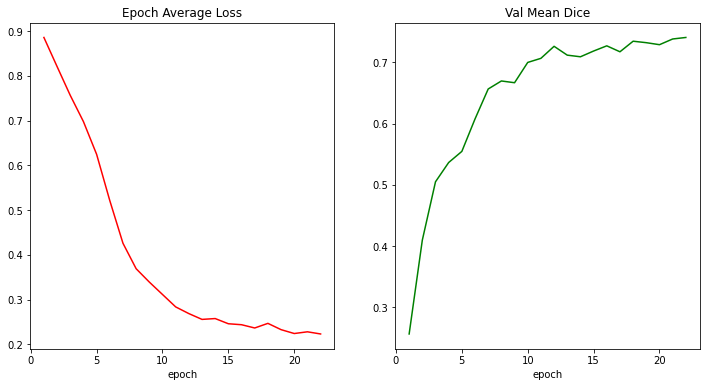

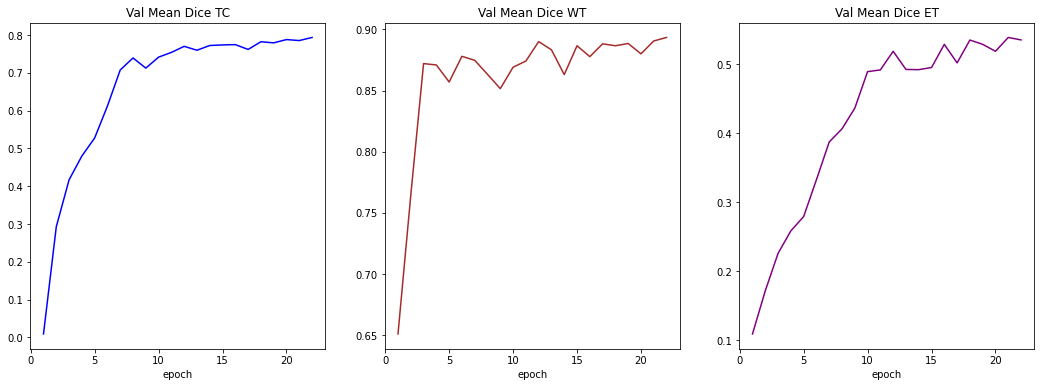

In [76]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

## Check best model output with the input image and label

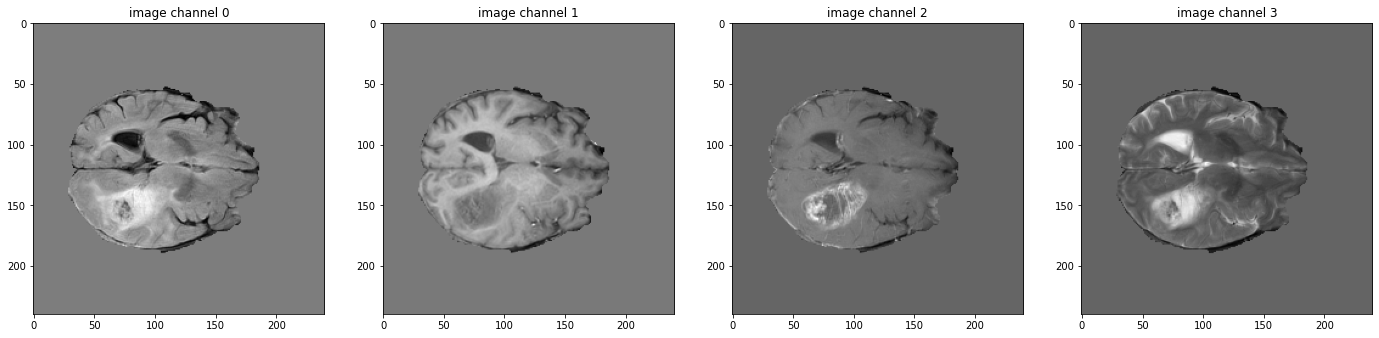

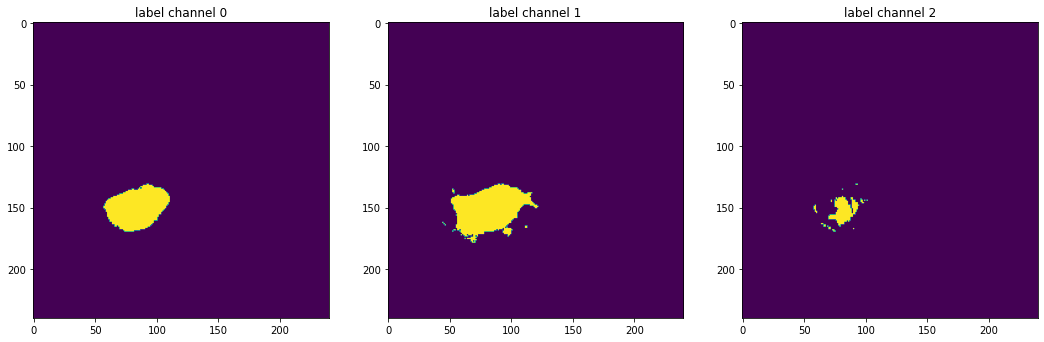

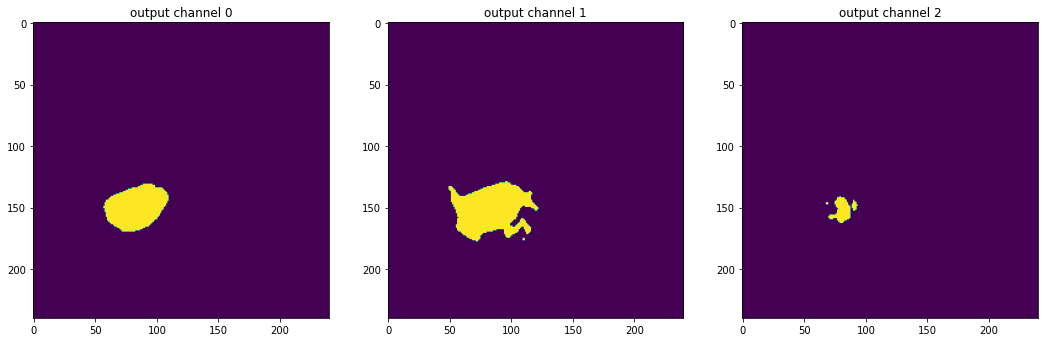

In [77]:
model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

## Evaluation on original image spacings

기존 validation transform
```python
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)
```

In [80]:
# 기존 transform과 비교하면 spacingd을 label빼고 image만 진행(mode도 달라짐), Orientationd도 image만 진행
# st7.spleen을 보면 spacing으로 dim size변화가 일어나기 때문에 Inverted 변화 필요
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),              
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),    ## 달라짐(label빠짐, mode 삭제)
        Orientationd(keys=["image"], axcodes="RAS"),                          ## 달라짐(label빠짐)
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(                                                                    ## 다시 기존으로 변경
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold=0.5),
])

torch.Size([1, 4, 240, 240, 155]) torch.Size([1, 3, 240, 240, 155])


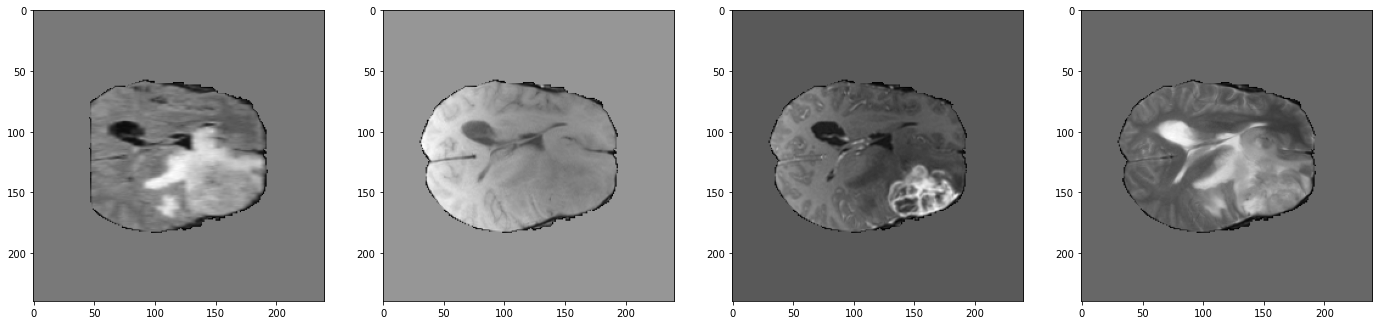

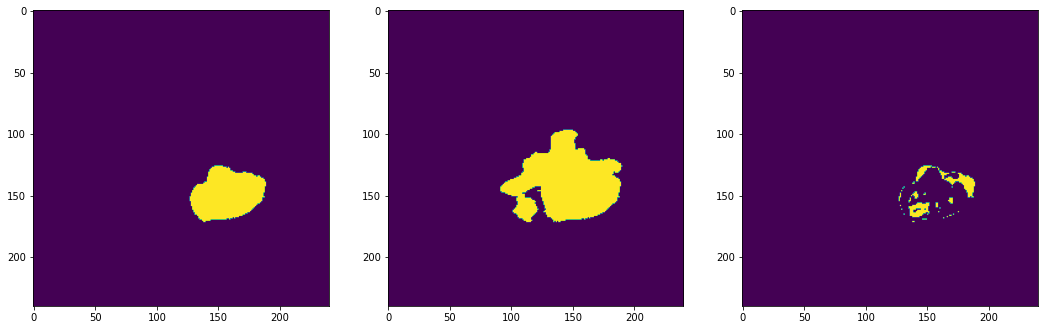

In [107]:
## transform 적용, 이후의 차이 실험
# spacingd의 pixdim은 1.0이 default로 변경 없는 듯

val_org_transforms_test = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),              
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),    ## 달라짐(label빠짐, mode 삭제)
        Orientationd(keys=["image"], axcodes="RAS"),                          ## 달라짐(label빠짐)
#         Orientationd(keys=["image", "label"], axcodes="RAS"),                          ## 달라짐(label빠짐)
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds_test = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms_test,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader_test = DataLoader(val_org_ds_test, batch_size=1, shuffle=False, num_workers=4)
bbb = next(iter(val_org_loader_test))

## 모두 적용시, (torch.Size([1, 4, 240, 240, 155]), torch.Size([1, 3, 240, 240, 155]))
## spacing 비활성화 : torch.Size([1, 4, 240, 240, 155]) torch.Size([1, 3, 240, 240, 155])
print(bbb['image'].shape, bbb['label'].shape) 

D = 80
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(bbb["image"][0, i, :, :, D].detach().cpu(), cmap="gray")
plt.show()

plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(bbb["label"][0, i, :, :, D].detach().cpu())
plt.show()

# with torch.no_grad():
#     for val_data in val_org_loader:
#         val_inputs = val_data["image"].to(device)
#         val_data["pred"] = inference(val_inputs)
#         val_data = [post_transforms(i) for i in decollate_batch(val_data)]
#         val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
#         dice_metric(y_pred=val_outputs, y=val_labels)
#         dice_metric_batch(y_pred=val_outputs, y=val_labels)

#     metric_org = dice_metric.aggregate().item()
#     metric_batch_org = dice_metric_batch.aggregate()

#     dice_metric.reset()
#     dice_metric_batch.reset()

# metric_tc, metric_wt, metric_et = metric_batch[0].item(), metric_batch[1].item(), metric_batch[2].item()

# print("Metric on original image spacing: ", metric)
# print(f"metric_tc: {metric_tc:.4f}")
# print(f"metric_wt: {metric_wt:.4f}")
# print(f"metric_et: {metric_et:.4f}")

In [81]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, a

In [82]:
with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch[0].item(), metric_batch[1].item(), metric_batch[2].item()

print("Metric on original image spacing: ", metric)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

Metric on original image spacing:  0.7405611872673035
metric_tc: 0.7934
metric_wt: 0.8934
metric_et: 0.5349


## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
# if directory is None:
#     shutil.rmtree(root_dir)